In [1]:
import rootpath
import sys
import os
sys.path.append(rootpath.detect())

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from testsuite.utilities import Pareto_split
from testsuite.optimisers import Saf
from testsuite.surrogates import GP, MultiSurrogate

In [3]:
import matplotlib
matplotlib.rcParams['font.size'] = 15 ;
matplotlib.rcParams['legend.fontsize'] = 15
matplotlib.rcParams['figure.figsize'] = (10, 8)

In [4]:
SCRIPT_DIR = os.getcwd()
def save_fig(fig, name=None):
    savedirs = [os.path.join(SCRIPT_DIR, "figures/"), '/home/finley/phd/papers/SAF-driven-EMO/presentation/SAF-EMO_presentation/figures']
    for d in savedirs:
        fig.savefig(os.path.join(d, name+".png"), dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait', pad_inches=0.12)
        fig.savefig(os.path.join(d, name+".pdf"), bbox_inches = 'tight', pad_inches = 0, dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait')

In [5]:
def image_infill(opt, front_value = 0., n_contours=20, uncertainty=0.1):
    #figure_properties
    fig = plt.figure(figsize=[8,7])
    ax = fig.gca()
    l_lims = opt.apply_weighting(np.array([[0, 0]]))
    u_lims = opt.apply_weighting(np.array([[1.5, 1.5]]))
    ax.set_xlim([0., 1.5])
    ax.set_ylim([0., 1.5])
    
    # compute infill
    M, N = 200, 200
    x = np.linspace(0., 1.5, M)
    y = np.linspace(0., 1.5, N)
    xx, yy = np.meshgrid(x, y)
    xy = np.vstack((xx.flat, yy.flat)).T
    xyw = opt.apply_weighting(xy)
    zz = np.array([opt._scalarise_y(xyi, np.ones_like(xyi)*uncertainty*opt.obj_weights, invert=False) for xyi in xyw])
    zz = zz.reshape(N,M)
    
    #image infill
    pcol = ax.pcolor(xx, yy, zz)
    levels = np.linspace(zz.min(), zz.max(), n_contours+2)[1:-1]
    ax.contour(xx, yy, zz, colors="white", levels=levels)
    if front_value is not None:
        ax.contour(xx, yy, zz, colors="C3", levels=[front_value])
        front_legend = plt.Line2D([0], [0], c="C3")
    
    # scatter samples
    ax.scatter(opt.d[:,0], opt.d[:,1], facecolors='none', edgecolors="C3", linewidth=2., label="dominated samples")
    ax.scatter(opt.p[:,0], opt.p[:,1], c="C3", label="non-dominated samples")
    fig.colorbar(pcol)
    handles, labels = ax.get_legend_handles_labels()
    if front_value is not None:
        handles.append(front_legend)
        labels.append("{}".format(front_value))
    ax.legend(handles, labels)
    
    return fig

In [6]:
seed = 1
INVERT = True
plt.rcParams['image.cmap'] = 'viridis'
from matplotlib.cm import viridis as cmap
n_contours=20

In [7]:
from testsuite.optimisers import Saf
saf_opt = Saf(objective_function=lambda x: x[0:2], ei=False,  limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)

In [8]:
x_ = np.array([0.42, 0.215])
stds = [0.005, 0.01]

 <ipython-input-5-0b3b2eabe5a0>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


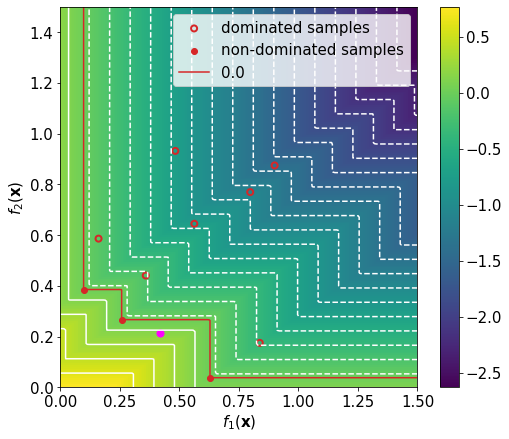

In [9]:
fig_saf = image_infill(saf_opt, n_contours=n_contours)
fig_saf.gca().set_xlabel("$f_1(\mathbf{x})$")
fig_saf.gca().set_ylabel("$f_2(\mathbf{x})$")
save_fig(fig_saf, name="figure32_saf_infill")

ax = fig_saf.gca() 
ax.scatter(*x_.T, c="magenta", s=50)
save_fig(fig_saf, name="figure40_saf_infill")

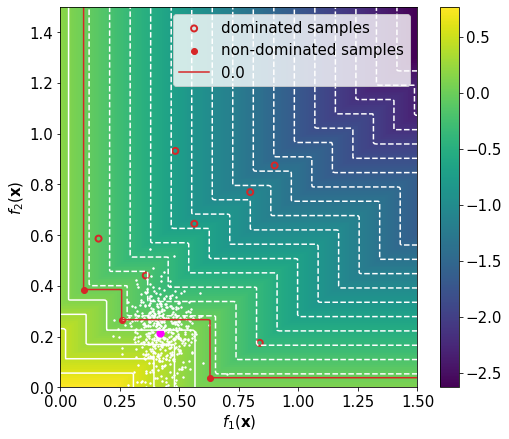

In [10]:
ax.scatter(*x_.T, c="w")
monte_points = np.random.multivariate_normal(x_, np.diag(stds), 500)
ax.scatter(*monte_points.T, c="white", s=2)
ax.scatter(*x_.T, c="magenta", s=50)
save_fig(fig_saf, name="figure41_saf_infill_scatter")
fig_saf

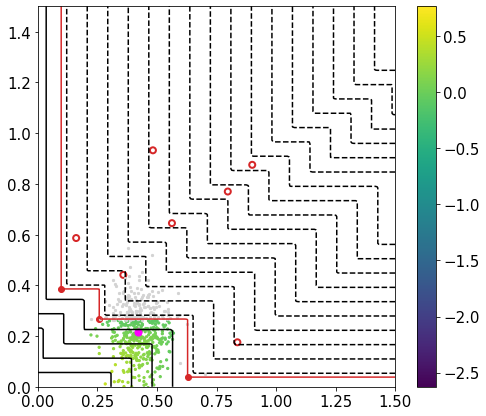

In [11]:
opt = saf_opt
fig = plt.figure(figsize=[8,7])
ax = fig.gca()
l_lims = opt.apply_weighting(np.array([[0, 0]]))
u_lims = opt.apply_weighting(np.array([[1.5, 1.5]]))
ax.set_xlim([0., 1.5])
ax.set_ylim([0., 1.5])
    
# compute infill
M, N = 200, 200
x = np.linspace(0., 1.5, M)
y = np.linspace(0., 1.5, N)
xx, yy = np.meshgrid(x, y)
xy = np.vstack((xx.flat, yy.flat)).T
xyw = opt.apply_weighting(xy)
zz = np.array([opt._scalarise_y(xyi, np.ones_like(xyi)*stds*opt.obj_weights, invert=False) for xyi in xyw])
zz = zz.reshape(N,M)

# contour plot
levels = np.linspace(zz.min(), zz.max(), n_contours+2)[1:-1]
conts = ax.contour(xx, yy, zz, colors='k', levels=levels)

# scatter samples
ax.scatter(opt.d[:,0], opt.d[:,1], facecolors='none', edgecolors="C3", linewidth=2., label="dominated samples")
ax.scatter(opt.p[:,0], opt.p[:,1], c="C3", label="non-dominated samples")

# monte scatter
monte_values = np.array([opt._scalarise_y(mp*opt.obj_weights, np.ones_like(mp)*stds*opt.obj_weights, invert=False)for mp in monte_points])
# monte_values = np.array([mv if mv>0 else 0. for mv in monte_values])
_min, _max = np.amin(fig_saf.axes[0].collections[0].get_array()), np.amax(fig_saf.axes[0].collections[0].get_array())
scat = ax.scatter(*monte_points[monte_values>-0.1].T, c=monte_values[monte_values>-0.1], s=5, vmin=_min, vmax=_max)
scat = ax.scatter(*monte_points[monte_values<=-0.1].T, c='lightgrey', s=5, vmin=_min, vmax=_max)
ax.scatter(*x_.T, c="magenta", s=50)
ax.contour(xx, yy, zz, colors="C3", levels=[0.])
front_legend = plt.Line2D([0], [0], c="C3")
fig.colorbar(fig_saf.axes[0].collections[0])

save_fig(fig, name="figure42_saf_infill_scatter_valued")